![Banner](img/AI_Special_Program_Banner.jpg)

## CRISP DM: Transfer Learning for Image Classification
---

&copy; Daniel Schaudt, Lucas Krenmayr, [Prof. Dr. Reinhold von Schwerin](https://www.thu.de/Reinhold.vonSchwerin), Technische Hochschule Ulm, September 2023

---

## Overview
- [Business Understanding](#Business-Understanding)
- [Data Understanding](#Data-Understanding)
  - [Try for Reproducibility](#Try-for-Reproducibility)
  - [Import of Libraries](#Import-of-Libraries)
  - [Loading the Image Data](#Loading-the-Image-Data)
- [Data Preparation](#Data-Preparation)
- [Modeling](#Modeling)
- [Evaluation](#Evaluation)
- [Deployment](#Deployment)
- [Where to go from here?](#Where-to-go-from-here?)
  - [Possible Improvements](#Possible-Improvements)
  - [Outlook](#Outlook)
  - [Develop better intuition](#Develop-better-intuition)
 
---

This notebook shall show an example of classifying images using Deep Learning methods for a relevant problem, especially in the trying times in the year 2020. In particular, we will be trying to predict whether someone is suffering from COVID-19 induced pneumonia by looking at chest X-rays. This is particularly relevant, since this appraoch to diagnosing COVID-19 is comparatively inexpensive and would be applicable almost everywhere. The project was inspired by a blog post by [Adrian Rosebrock](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/) and mostly builds on the code provided there, but a different set of X-rays.

**Please note that neither we, nor the author of the aforementioned blog post make a claim as to the *medical* validity of what we are doing! This would have to be evaluated by MDs (luckily, [there are some](https://www.regio-tv.de/mediathek/video/kuenstliche-intelligenz-im-kampf-gegen-corona-neues-forschungsprojekt-in-ulm/) who are willing to do just that!). Here, we just want to point out the *technical* possibilities - i.e., we want to provide a *proof of concept* (PoC)**

The technology we employ is [`Python`](https://www.python.org/) together with the [`PyTorch`](https://pytorch.org/) library. Any other libraries just serve as helper libraries for data (pre-)processing. 

The **message** we want to convey with this notebook, however, is a different one. We want to show that, contrary to popular belief, it *may* be possible to obtain good results using Deep Learning with just a medium or even a small amount of data (to be concrete: 154 X-rays for this demo). Thus, even collecting your own data and *labelling* it by hand may lead to success.

**Remarks:**
* Again in this notebook, for those interested in going deeper, we provide references which give more detailed information on some of topics. 
* To be precise, also for the application we aim at in this notebook, we need a lot of training data for the whole model. However, we can use a *pre-trained* model (see below), so that we can do with a small amount of data for the *specific application* - this is the idea behind ***transfer learning***

In addition, we shall employ the well-established [CRISP-DM model](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) for the project presented in this notebook to provide structure. The model consists of the following *phases*:

![CRISP-DM](./img/Cross-Industry-Standard-Process-for-Data-Mining-CRISP-DM-12_s.png "CRISP-DM")

Thus, the headings in this notebook corrrespond exactly with the CRISP-DM phases and the short descriptions of the phases are taken from [Pete Chapman et al](ftp://ftp.software.ibm.com/software/analytics/spss/support/Modeler/Documentation/14/UserManual/CRISP-DM.pdf).

## Business Understanding
---

> **From CRISP-DM 1.0:** *This initial phase focuses on understanding the project objectives and requirements from a business perspective, then converting this knowledge into a data mining problem definition and a preliminary plan designed to achieve the objectives.*

During of the Corona pandemic, medical personell in hospitals needed all the support and help they could get. One such value added support technique would be an automated classification of medical images. In case of Covid-19, this idea to classify X-rays actually arose from pure necessity. Due to a shortage of Covid-19 tests, for a certain period of time  [Covid-19 cases in China were classified based on X-rays and/or CT scans](https://www.statnews.com/2020/02/20/experts-say-confusion-over-coronavirus-case-count-in-china-is-muddying-picture-of-spread/). This type of classification, however, is error prone, since Covid-19 induced pneumonia cannot be very well distinguished from other types of pneumonia.

**Once again: this notebook does not claim to provide any medical or scientific value and only serves for demonstration purposes. We want to make clear, however, that there is a real world application behind what we are investigating here (and, last but not least, our partners at the Uniklinik Ulm do see potential in this approach and are willing to investigate it further together with us).**

## Data Understanding
---

> **From CRISP-DM 1.0:** *The data understanding phase starts with initial data collection and proceeds with activities that enable you to become familiar with the data, identify data quality problems, discover first insights into the data, and/or detect interesting subsets to form hypotheses regarding hidden information.*

### Try for Reproducibility
---
We set various [random seeds](https://de.wikipedia.org/wiki/Seed_key) in order to obtain a deterministic way of training our models so as to make the results *reproducible*:

In [1]:
RSEED = 42
import os
os.environ['PYTHONHASHSEED']=str(RSEED)
import random
random.seed(RSEED)
from numpy.random import seed
seed(RSEED)
import torch
torch.manual_seed(42)
import numpy as np
np.random.seed(42)

**Remark:** Unfortunately, this will only lead to *local reproducibility*, i.e., the results will be the same on a specific machine, as long as all other model parameters remain unchanged (see below). However, when transfering onto a different machine, we can see the phenomenon described by  [Jason Brownlee](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/) in section *Randomness from a Sophisticated Model*. Thus, you can expect to obtain different results to the ones presented here if you run this notebook in your own environment (see also section **Evaluation**). Anyway, you sould take Brownlee's recommendation to heart and assess model performance by running it multiple times (see the link above).

### Import of Libraries
---

We start, as usual, by importing the libraries we need. Here, we also provide a short description with links to their respective documentation (and, possibly, extra documentation):
* [PyTorch](https://pytorch.org/): is a machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, originally developed by Meta AI and now part of the Linux Foundation umbrella.
* [scikit-learn](https://scikit-learn.org/stable/): Another ML library, but really only useful for classical ML methods. Here, we employ it in the context of evaluation.
* [mlxtend](http://rasbt.github.io/mlxtend/): a contribution by  [Sebastian Raschka](https://sebastianraschka.com/) to extend the possibilities of ML in Python (also see his [Blog](https://sebastianraschka.com/blog/index.html) which is well worth a look).
* [Pillow (PIL)](https://pillow.readthedocs.io/en/stable/): PIL is the acronym for *Python Image Library* and will be used here for displying and processing the image data.
* [matplotlib](https://matplotlib.org/index.html): for visualizations and plots.
* [numpy](https://numpy.org/): a powerful library for scientific (numerical) computing.

In [2]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.densenet import DenseNet121_Weights
import torch.nn.functional as F

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import pathlib
import IPython.display as display
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

%matplotlib inline

# force gpu computing, when gpu library is available
USE_GPU = True

import datetime as dt

# finally, we will use our train loop again
from train_loop import train, train_for_epochs, validate, plot_history

Just to be thorough, we also document the date the notebook was run as well as the versions of `PyTorch` and `numpy` we use:

In [3]:
print(f'This notebook was run on {dt.date.today()}')
print(f'The version of PyTorch is {torch.__version__}')
print(f'The version of NumPy is {np.__version__}')

This notebook was run on 2024-01-28
The version of PyTorch is 2.1.2
The version of NumPy is 1.26.3


### Loading the Image Data
---

> The images of Covid-19 patients were found in a dataset by [Jospeh Paul Cohen](https://github.com/ieee8023/covid-chestxray-dataset) on March 24th, 2020. The images of patients without pneumonia can be found in [Kaggle's Chest X-Ray Images dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

In order to work with the data, we first have to load it. The data is available in the following folder structure:

```
data/Covid
├───train
│   ├───covid
│   └───normal
└───valid
    ├───covid
    └───normal
```

The folders `train`and `valid` contain training and validation data respectively. the sub-folders `covid`and `normal` contain images which are labelled corresponding to the folder names. The model is *trained* using the training data and by using the validation data, we try to assess the ability of the model to *generalize*. In the context of ML. this means that the model does not just *learn* the data it has already seen *by heart*, but instead it is able to transfer the knowledge it gained to new, as yet unseen data.

This kind of evaluation technique is known as a [*holdout strategy*](https://www.kdnuggets.com/2017/08/dataiku-predictive-model-holdout-cross-validation.html). Actually, an effective and correct evaluation is arguably the most important part in ML. If you get this wrong, you have no way of knowing whether your model is suited for practical use. More on the issue may be found in the excellent book [Deep Learning by Ian Goodfellow et al.](https://www.deeplearningbook.org/contents/ml.html) (chapter 5.2) as well as in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

The way we load the image data follows the official [PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

We start by specifying the path and counting the images.

In [4]:
data_dir = pathlib.Path('./data/Covid')

In [5]:
train_image_count = len(list(data_dir.glob('train/*/*')))

In [6]:
train_image_count

134

In [7]:
valid_image_count = len(list(data_dir.glob('valid/*/*')))

In [8]:
valid_image_count

20

The class names (*labels*) can be extracted from the folder names:

In [9]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('train/*')])
CLASS_NAMES

array(['normal', 'covid'], dtype='<U6')

We use `display.display` to show an example of an image from a symptom-free patient.

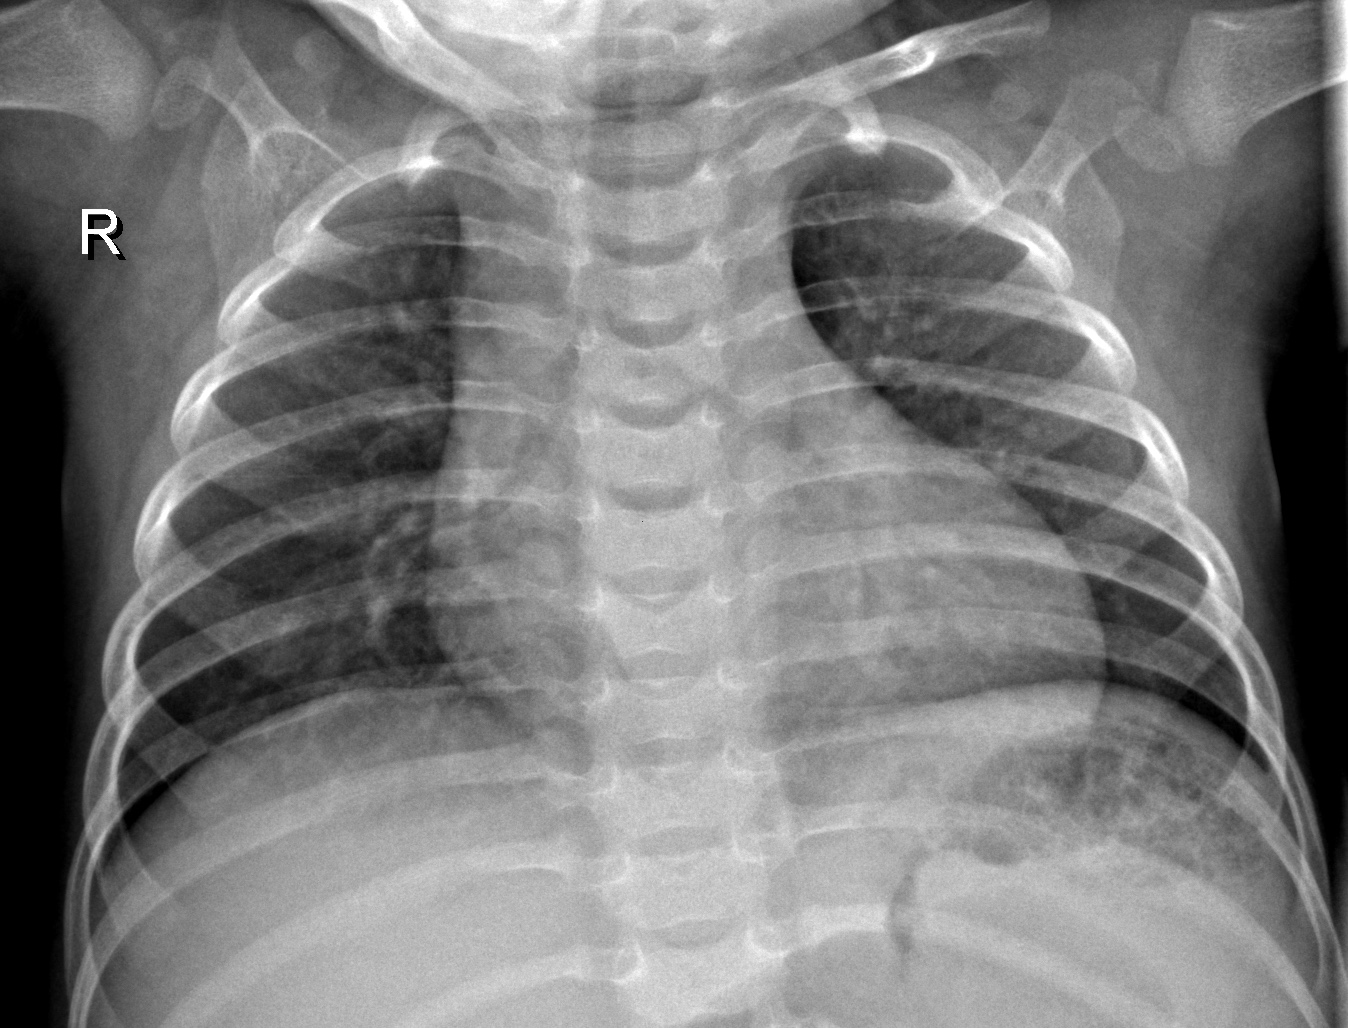

In [10]:
image_list = list(data_dir.glob('train/normal/*'))
display.display(Image.open(str(image_list[2])))

For comparison, here is an image of someone with Covid-19 induced pneumonia:

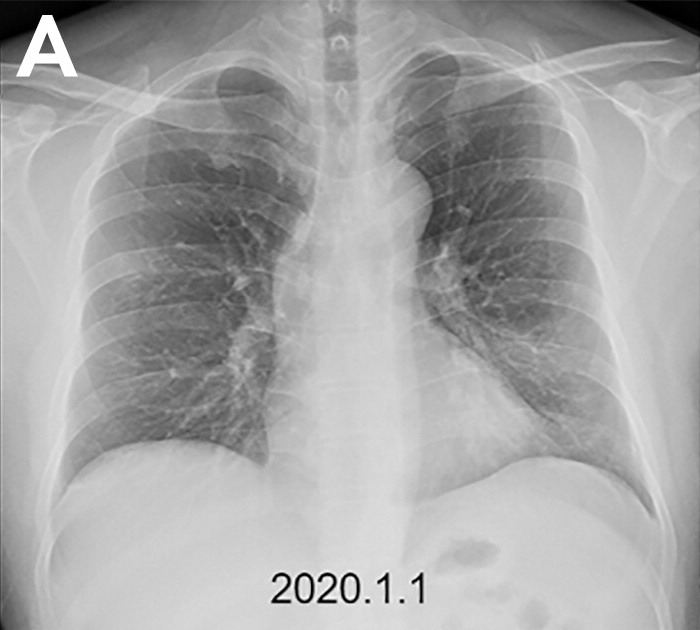

In [11]:
image_list = list(data_dir.glob('train/covid/*'))
display.display(Image.open(str(image_list[7])))

Without medical training and the adequate medical specialization, a neutral observer / layman surely cannot do a lot with these images. It is not clear, which *features* in the image contribute to the classification of pneumonia.

## Data Preparation
---

> **From CRISP-DM 1.0:** *The data preparation phase covers all activities needed to construct the final dataset [data that will be fed into the modeling tool(s)] from the initial raw data. Data preparation tasks are likely to be performed multiple times and not in any prescribed order. Tasks include table, record, and attribute selection, as well as transformation and cleaning of data for modeling tools.*

In this phase we transform the image data in such a way that they become suited as input for the ML model. We do this by using the predefined Dataset `ImageFolder`. This dataset loads image data and derives the labels based on the folder structure. We also define a preprocessing pipeline which scales the images to a standard width and height, converts the images to tensors and scales the values ($\hat=$ *pixel intensity*) of the individual pixels scaled down from \[0-255\] to the interval  \[0-1\].
The neural network (NN) employed later multiplies these initial values multiple times during *forward* and *backward passes* through the *layers* of the model, i.e. when coumputing the current outputs as well as the weight updates. Therefore, scaling the input values makes the training process more stable, as it is one way of mitigating a phenomenon known as *vanishing gradient* or *exploding gradient*. For more information see [Yann LeCun et al.](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf).

In [12]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

# preprocessing pipeline 

# transformation for normalizing the data
class Normalize(object):
    def __call__(self, tensor):
        return tensor / tensor.max()
    
# we can compose multiple transformation steps into a transformation pipeline
transform = transforms.Compose([
    #rescale to (IMG_HEIGHT/IMG_WIDTH)
    transforms.Resize(size=(IMG_HEIGHT, IMG_WIDTH), antialias=True),
    #convert image to tensor
    transforms.PILToTensor(),
    #normalize the data
    Normalize()
])  


dataset_train = ImageFolder(root="data/Covid/train", transform=transform, target_transform=lambda y: torch.tensor(y))
dataset_valid = ImageFolder(root="data/Covid/valid", transform=transform, target_transform=lambda y: torch.tensor(y))
dataset_train, dataset_valid

(Dataset ImageFolder
     Number of datapoints: 134
     Root location: data/Covid/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                PILToTensor()
            )
 Target transform: <function <lambda> at 0x7f1cb13ff100>,
 Dataset ImageFolder
     Number of datapoints: 20
     Root location: data/Covid/valid
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                PILToTensor()
            )
 Target transform: <function <lambda> at 0x7f1cb13fe980>)

We then define the following parameters:
* **BATCH_SIZE:** This denotes the number of images used for one *pass* through the NN. This parameter serves two main purposes:
  1. optimization of memory usage
  2. for model training
  
Choosing the appropriate batch size can be a challenge. For an introduction / discussion see [Michael Nielsen](http://neuralnetworksanddeeplearning.com/chap2.html) or chapter 8.1.3 of [Ian Goodfellow et al.](https://www.deeplearningbook.org/contents/optimization.html).

In [13]:
BATCH_SIZE = 6

We now transform the dataset to a dataloader for easier iteration and batching (see the [dataloader tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)).

In [14]:
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
dataloader_valid= DataLoader(dataset_valid, batch_size=1, shuffle=False)

We can visualize an individual batch using the following function:

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(BATCH_SIZE//2,BATCH_SIZE//2,n+1)
        plt.imshow(image_batch[n].permute(1, 2, 0))
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

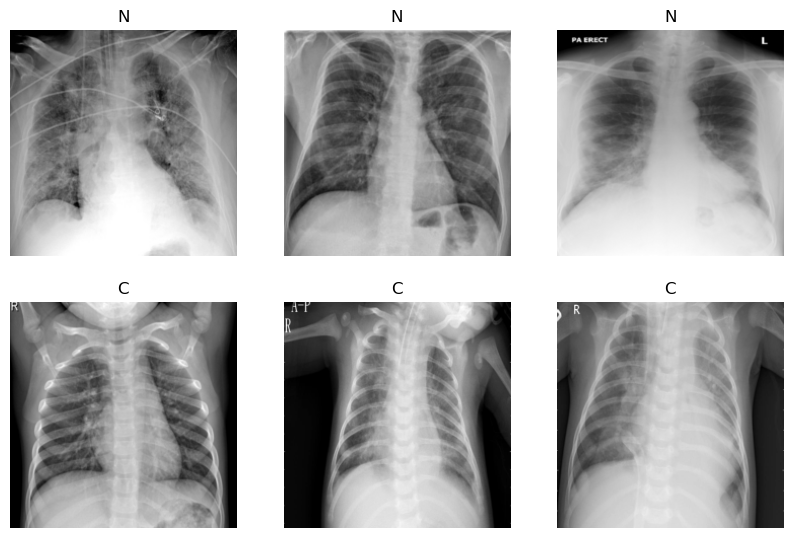

In [17]:
image_batch, label_batch = next(iter(dataloader_train))
show_batch(image_batch, label_batch)

This concludes the preparation of the data for training and validation using a NN.

## Modeling
---

> **From CRISP-DM 1.0:** *In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques have specific requirements on the form of data. Therefore, going back to the data preparation phase is often necessary.*

In this section, we will build and train the ML model. For image recognition tasks, the state of the art has for some time been *Convolutional Neural Networks* (CNN). They have a special *architecture* which lends itself very well to the task. Using self-taught *filters* (aka *kernels*), they recognize patterns in the data:

![CNN](./img/cnn.png "CNN")

> The image is taken from [Adit Deshpande](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/), which gives an understandable introduction to CNNs.

Further information on NNs in general and on CNN in particular may be found, e.g., in:
* an excellent introduction to NNs by Grant Sanderson (3Blue1Brown), a [must watch!](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
* The basic concept of NNs with interactive examples and visualization: [Jay Alammar](https://jalammar.github.io/visual-interactive-guide-basics-neural-networks/)
* CNN basics with instructive visualizations: [Adit Deshpande](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/)
* Intuition on the way a CNN works: [Christopher Olah](https://colah.github.io/posts/2014-07-Conv-Nets-Modular/)

Some more (hyper-)parameters to be set:
* **EPOCHS:** one *epoch* denotes a complete run through all training examples.
* **INIT_LR:** the initial learning rate of the model. An additional explanation on the model training may be found in [Nielsen](http://neuralnetworksanddeeplearning.com/chap2.html) (among others).

In [18]:
EPOCHS = 8
INIT_LR = 3e-5

In the following, we build the CNN model. To be precise, we need two models
* a *baseModel* and
* a *headModel*

The *baseModel* is a *pre-trained* model, which learned the classifications from millions of images ([ImageNet](http://www.image-net.org/)) (or, to be precise again, it learned the *weights* of the connections between the various layers of the NN). The *headModel*, on the other hand, constitutes a new *top part*, aka *head*, for the base model, which is adapted to the particular area of application tackled here. 

This technique is known as [Transfer Learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/). This makes it possible to train ML models with just a small amount of data (as we will show here). Intuitively, the base model already incorporates a lot of knowledge (in our case concerning features to look for in images), so we only need to do some fine-tuning.

Concretely, we will be using a [DenseNet](https://arxiv.org/abs/1608.06993) as our base model:

In [19]:
base_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights=DenseNet121_Weights.DEFAULT)

Using cache found in /home/rvs/.cache/torch/hub/pytorch_vision_v0.10.0


In [20]:
# if you would like to look at the model structure uncomment the following line and run
# base_model

In [21]:
base_model.classifier

Linear(in_features=1024, out_features=1000, bias=True)

The loaded model is trained on prediciting one of ImageNet´s 1000 classes (see, e.g., [PyTorch DenseNet](https://pytorch.org/hub/pytorch_vision_densenet/) )<br>
Therefore we will replace the classifier head with our own head model. 

In [22]:
class HeadModel(nn.Module):
    def __init__(self, in_features=1000):
        super(HeadModel, self).__init__()
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features=in_features, out_features=64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=64, out_features=1)
        
    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
    
head_model = HeadModel(in_features=base_model.classifier.in_features)
head_model

HeadModel(
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

Thus, the *headModel* is made up of two Fully-Connected-Layers at its core with two output neurons, corresponding to the classes *covid* and *normal* in our case. The additional layers do not provide any *learnable parameters*, but serve important purposes as well:
* *dropout* is a very important *regularization technique* aimed at obtaining a model which *generalizes well* (for more information on this issue see [Brownlee](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)).

We finally concatenate the base model and the head model into an overall `model`:

In [23]:
class FinalModel(nn.Module):
    def __init__(self, base_model, head_model):
        super(FinalModel, self).__init__()
        self.base_model = base_model
        # exchange the classifier layer of the base model with the identity function
        # the identity function just returns the input as output -> https://pytorch.org/docs/stable/generated/torch.nn.Identity.html
        self.base_model.classifier = nn.Identity()
        self.head_model = head_model
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.base_model(x)
        x = self.head_model(x)
        x = self.sigmoid(x)
        return x

final_model = FinalModel(base_model=base_model, head_model=head_model)

Now we have to make sure that we *freeze* the layers of the base model in order not to update its weights by the gradient updates (which would make training last much longer; see [Nielsen](http://neuralnetworksanddeeplearning.com/chap2.html) once again for more information on training NNs).

In [24]:
for param in final_model.base_model.parameters():
    param.requires_grad = False

The adaptation of the weights is done using the *Adam* optimizer, an improved variant of *stochastic gradient descent*. A brief overview is again provided in a blogpost by [Jason Brownlee](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) (but you can just use it as well or dive even deeper into the topic with [towards data science](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c) ...).

In [25]:
# Define the loss function - cross entropy for the binary case
criterion = nn.BCELoss()

# Define the optimizer
# Observe that only parameters of the head model are being optimized
optimizer = optim.Adam(final_model.head_model.parameters(), lr=INIT_LR)

In [26]:
# if you would like to look at the model structure uncomment the following line and run
# final_model

When run, the output displays the complete *architecture* of the network, i.e., it shows all layers starting from the top of the network (input layer) to the bottom (output layer). Furthermore, the size of the individual layers as well as their connections can be reviewed. We can see that the base model consists mainly of blocks of Conv2D, BatchNormalization und ReLu activations (where *batch normalization* aids in stabilizing the training process - again [Brownlee](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/) provides more on that). At the bottom of the summary we find the head model we defined earlier.

Now we are finally ready to train the model using our well-known training functions:

In [27]:
# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() and USE_GPU else "cpu")
print(f'Using {device} for training the network')

# Move the model weight to the desired device
final_model.to(device)

start_train = dt.datetime.now()
print(f'Starting training: {start_train}')

# run training, set binary to false since we have a multi label classification
#history = train_for_epochs(device, EPOCHS, final_model, dataloader_train, dataloader_valid, optimizer, criterion, binary=True)
history = train_for_epochs(device, EPOCHS, final_model, dataloader_train, dataloader_valid, 
                           optimizer, criterion, binary=True, unsqueeze=True)

finish_train = dt.datetime.now()
print(f'Training finished: {finish_train} (duration: {finish_train - start_train})')

Using cuda for training the network
Starting training: 2024-01-28 22:58:18.673159


  0%|          | 0/8 [00:00<?, ?it/s]

Training finished: 2024-01-28 22:58:42.966837 (duration: 0:00:24.293678)


## Evaluation
---

> **From CRISP-DM 1.0:** *At this stage in the project, you have built a model (or models) that appears to have high quality from a data analysis perspective. Before proceeding to final deployment of the model, it is important to thoroughly evaluate it and review the steps executed to create it, to be certain the model properly achieves the business objectives. A key objective is to determine if there is some important business issue that has not been sufficiently considered. At the end of this phase, a decision on the use of the data mining results should be reached.*

In this section, we investigate the performance of our model. We will exemplify this using some widely used metrics. In order to obtain those, we must first see what the model predicts for the validation data so that we can compare it to the *ground truth* we already know. We obtain the predictions using the forward call of the model: 

In [28]:
valid_batch = next(iter(dataloader_valid))
valid_img = valid_batch[0].to(device)
valid_target = valid_batch[1].to(device)
final_model.eval()
with torch.no_grad():
    predIdx = final_model(valid_img)
predIdx

tensor([[0.4678]], device='cuda:0')

Actually, the model returns the *probabilities* for an image being pneumonia positive. In order to make the binary decision for the class, we round the probabilities using the function `torch.round()`:

In [29]:
predIdx = torch.round(predIdx)
predIdx

tensor([[0.]], device='cuda:0')

The predictions then have to be compared to the ground truth labels:

In [30]:
predIdx == valid_target

tensor([[True]], device='cuda:0')

We now do this for all entries in the validation data set by iterating over it:

In [31]:
predIdxs = torch.zeros(len(dataset_valid)) # init empty tensor to store predictions
y_valid = torch.zeros(len(dataset_valid)) # init empty tensor to store targets
final_model.eval()
for i, (img, target) in enumerate(dataset_valid):
    img = img.to(device).unsqueeze(0) # move to device and add batch diemsnion
    target = target.to(device) # move to device
    with torch.no_grad():
        predictIdx = final_model(img)
    predIdxs[i] = torch.round(predictIdx).squeeze()
    y_valid[i] = target
    
predIdxs = predIdxs.long().cpu().numpy() # convert to numpy array
y_valid = y_valid.cpu().long().numpy() # convert to numpy array

predIdxs == y_valid # compare predictions and targets

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

The library `Scikit-learn` offers a `classification_report()`. This constitutes a straight forward way of presenting the most important metrics:

In [32]:
print(classification_report(y_valid, predIdxs, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      normal       1.00      0.90      0.95        10
       covid       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



The aggregated classifications may also be presented in the form of a [confusion matrix (aka contingency table)](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers):

In [33]:
cm = confusion_matrix(y_valid, predIdxs)

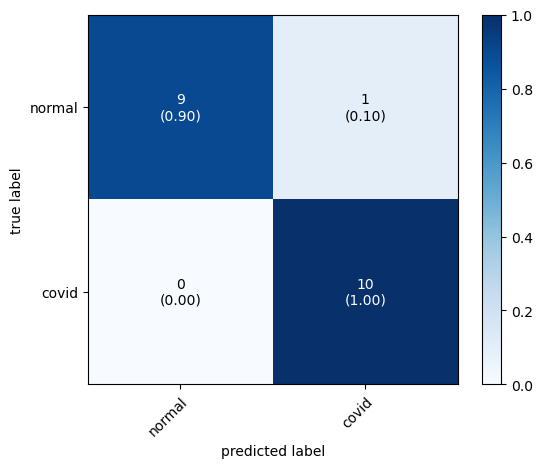

In [34]:
fig, ax = plot_confusion_matrix(conf_mat=cm, 
                                class_names=CLASS_NAMES,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

**Assessment** The model achieves an accuracy of 95% (=19/20). Furthermore, the values *precision* and *recall* are of particular interest: of the Covid-19 cases, the model gets 10 out of 10 right giving a *recall* of 100%. If the model thinks an image is that of a Covid-19 patient, it is right in 9 out of 11 cases, (9/11=91%; *precision*). For the normal cases, the situation is reversed: 9 out of 10 normal cases are predicted as such, giving a recall of 90%, whereas if the model thinks an image is that of a normal case, it is right 9 out of 9 times, giving a precision of 100%. 

In our particular area of application we are very proud of this result, since not diagnosing someone as having contracted Covid-19 despite the fact that he or she has is certainly worse than just having another look, since, obviously, by falsely discharging contagious patients we do not only put the patient him- or herself at risk, but also others.

Further information on the statistical quantities (like, e.g., the f1-score shown in the classification report) may be found in this [blogpost](https://koopingshung.com/blog/machine-learning-model-selection-accuracy-precision-recall-f1/) for example.

**Note:** All these values can tell us here is whether it makes sense to continue our investigations in this direction (we think so - the first results look promising). *However, the amount of validation data is so small that we cannot really asses the model quality in a statistically significant fashion **and we make no claim for this to be the case!***.

Finally, since the model collects the performance metrics during training and keeps it in `history`, we can visualize their development during training:

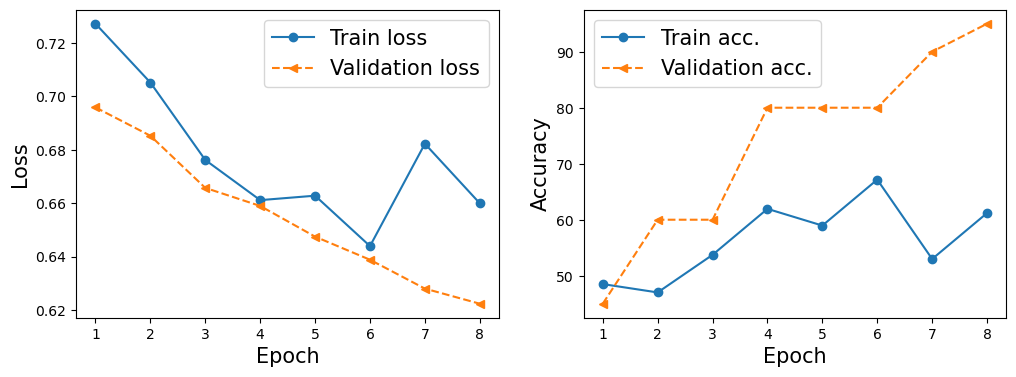

In [35]:
plot_history(history['train']['loss'], history['train']['accuracy'], history['val']['loss'], history['val']['accuracy'])
plt.show()

It seems odd, the validation accuracy is nearly always better than training accuracy and validation loss is always less than training loss - not something we would generally expect. However, due to the very small number of samples, it is hard to investigate these findings further (until we obtain more data ...). Anyway, it sure seems as if there is *no overfitting*, but this would also have to be investigated. Such questions try to assess *model capacity*, information on which may be found in chapter 5.2 of [Ian Goodfellow et al.](https://www.deeplearningbook.org/contents/ml.html).

## Deployment
---

> **From CRISP-DM 1.0:** *Creation of the model is generally not the end of the project. Even if the purpose of the model is to increase knowledge of the data, the knowledge gained will need to be organized and presented in a way that the customer can use it. It often involves applying “live” models within an organization’s decision making processes—for example, real-time personalization of Web pages or repeated scoring of marketing databases. Depending on the requirements, the deployment phase can be as simple as generating a report or as complex as implementing a repeatable data mining process across the enterprise. In many cases, it is the customer, not the data analyst, who carries out the deployment steps. However, even if the analyst will carry out the deployment effort, it is important for the customer to understand up front what actions need to be carried out in order to actually make use of the created models.*

In this phase we would like to put our model into production, i.e., we want to *deploy* it. In our scenario, we could envision an API allowing to provide a fresh chest X-ray from sources available in the hospital and assisting the medical personell with a second opinion returned by the AI. This is just one possible way of deployment - others are certainly conceivable. This, however, is not part of the intended demonstration in this notebook, but maybe the reader is interested in trying something out? In any case, it should be noted that PyTorch models may be saved, exported and ported. More information can be found on [Pytorch save and load models](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

## Where to go from here?
---

### Possible Improvements

The ML model presented here was meant as an introduction to the topic of *Transfer Learning* and provides a *skeleton* to be used as a starting point for further improvement. Such improvements are possible at various points and the interested reader is urged to try some of them out. In the following, we will present some such ideas for improvement, but these do by no means constitute a complete list: 

* **Modification of hyper parameters:** Hyper parameters are those parameters the network does *not learn* during training. Instead, they are provided beforehand by the data scientist working on the project. Here, some of the hyper paramaters we used are the *learning rate*, the *batch size*, the number of *epochs*, the *optimizer* used but also the *metrics* to be used for the optimization criterion and numerous other values. These pre-defined values often have a huge impact on the training of a NN and their composition forms a somewhat instable construct, where small changes can make a big difference regarding the efficiency of the resulting network. Thus, *tuning* those hyper parameters requires at least some basic understanding of their effects. Modification of the parameter values may then be done by *trial and error* or, alternatively, using (stochastic) search algorithms which try to find an optimal model within some hyper parameter space. A library that fits well with PyTorch is [Optuna](https://optuna.org/).
* **Training the baseModel:** So far, we only trained the *headModel*, while the layers of the *baseModel* were frozen. In practice, however, it makes sense to unfreeze these layers after an intial training and thus make their weights adaptable also. Intuitively, this will *fine tune* the weights for the given use case. A way of doing that is described in the official [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).
* **Using a different pre-trained model:** Here, we employed a network called *DenseNet*. This CNN from the year [2016](https://arxiv.org/abs/1608.06993) yields promising results *out of the box* and employs modern reularization strategies in deep neural nets. Concretely, parts of the neurons of the layers are *turned of randomly* during training. This approach has a lot of (theoretical) merits, but is is unclear whether this approach is well suited for the use case under consideration. `PyTorch` actually offers a wiede variety of other pre-trained nets in `torchvision.models` which may be used for further experimentation. An overview is available in the [documentaion](https://pytorch.org/vision/stable/models.html). The interested reader is advised to get some basic idea about the architecture of the network she or he wants to *try out* and then do just that in an empirical fashion.
* **Obtain more data:** Deep Learning models (as well as ML models in general) can always be improved with additional data (of adequate quality). Intuitively, additional data will make the model learn a representation of the data more closely resembling the true distribution of the data. Furthermore, DL models scale linearly with additional data (for a good intuition see [Kilian Weinberger (9:40)](https://youtu.be/kPXxbmBsFxs?t=579)). Another significant advantage is the higher number of validation samples, making the results of validation more statistically significant, which is absolutely necessary for production use. In our case, the dataset curated by [Jospeh Paul Cohen](https://github.com/ieee8023/covid-chestxray-dataset) has grown significantly from the time we obtained the data for this notebook (on March 24th, 2020) and also the images of patients without pneumonia we took from [Kaggle's Chest X-Ray Images dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) are not all there are available - so more data is up for grabs as of now!
* **Data Augmentation:** As mentioned before, an ML model aims at good *generalization*, meaning that as yet unseen data shall be handled correctly. One way of boosting the generalization property is an artificial extension of the training data. This process is known as *Data Augmentation* and can be done in various ways, especially in the context of image processing. The idea is to artificially produce images which still correctly represent the underlying feautures, but differ from the original. For images, this may, e.g., be done by mirroring the image (aka *flipping*), changing the color levels, adapting the section of the image (aka *cropping*), rotation and many more. The idea is to make the network *more robust* and thus generalize better. Hints as to how to do this in practice can be found in the official [PyTorch tutorial](https://pytorch.org/vision/main/transforms.html). But, **watch it:** not every technique is suited for every use case! In the case of X-rays, changing color levels or flipping will render the resulting images invalid.

Every time we modify a model, we must be wary of a principle which may be viewed as a **central problem of Machine Learning** namely the *bias-variance-tradeoff* or **underfitting vs overfitting!** This [blogpost](https://www.analyticsvidhya.com/blog/2020/02/underfitting-overfitting-best-fitting-machine-learning/) provides an intuitive, non-technical overview of the problem.

Intuitively, we aim for an ML model which by means of training gains an *understanding* for the data it is trained with and is able to *transfer* that knowledge onto other data. What is problematic is, if the model
* never reaches this understanding because the model is *not complex enough* to capture the intricacies of the data
* just learns the training data *by heart* and loses its capability for *generalization*

The first case is called *underfitting* and the second *overfitting*. The *capacity* of the model, i.e., its potential to deal with complex data structures always has to match the actual data in a project. Both regimes are illustrated by the following figure:

![Capacity](./img/capacity_orig.png "capacity")

In practice, there are numerous techniques to adapt a model's capacity and thus avoid overfitting respectively underfitting. The reader wishing to dive deeper into the theory of capacity is once again referred to chapter 5.2 of [Ian Goodfellow et al.](https://www.deeplearningbook.org/contents/ml.html), where the figure above is taken from.

### Outlook
---

Possible projects based on the introduction given in this notebook should ideally *deploy* the model in a real world application. Thus, first of all, the interested reader is required to come up with her or his own project idea, i.e., the *business understanding* part. Also, for final deployment, the topic of *serving* a model must be clarified, possible with the help of [Flask](https://pytorch.org/tutorials/intermediate/flask_rest_api_tutorial.html), but there are many other ways of deployment which can be found via appropriate web searches.

Apart from the task exemplified in this notebook (*image classification*) there are many more image related use cases in DL. Some of the most interesting are:
* **object detection:** Instead of classifying an entire image, object detection seeks to find and classify individual objects in an image. An introduction to this area of application may again be found on [Jason Brownlee's blog](https://machinelearningmastery.com/object-recognition-with-deep-learning/). A sub-category of this problem is *object segmentation*, i.e., an exact separation of objects in an image accurate to the pixel level. More information on this type of problem may again be found in a Pytorch [tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).
* **Generative Models:** *Generative Adversarial Networks (GANs)* work in a different way to the model presented here. First of all, the output of a GAN is not a classification, but another image! Furthermore, a GAN consists of two NNs which compete against each other in order to generate new, synthetic instances of data which ideally cannot be distinguished from real data. GANs are mainly employed for image generation, video generation (*deep fakes*), but also voice generation. A fun introduction to image generation using a modern variant called GANILLA may be found at [Two Minute Papers](https://www.youtube.com/watch?v=-IbNmc2mTz4&t=). Another good introduction but on a more techninal lever is given by [Arxiv Insights](https://www.youtube.com/watch?v=dCKbRCUyop8). And for deep fakes, you can watch another funny episode by [Two Minute Papers](https://www.youtube.com/watch?v=mUfJOQKdtAk). However, GANs are not just for fun. In fact, they might provide a very sophisticated way of performing *data augmentation*, if the generator's deep fakes can fool a doctor, then these deep fakes could be used for training a classification model ...

### Develop better intuition
---
You might have heard already that neural networks are best trained on graphics cards, which is why [Nvidia contributes heavily to AI](https://www.nvidia.com/de-de/deep-learning-ai/education/). By opening a developer account at the **D**eep **L**earning **I**nstitute, it is possible to enrol in free courses (as well as paid ones), which are mostly built around Jupyter notebooks like the present one. A good follow up to this introduction is the basic course they offer on [Image Classification using DIGITS](https://courses.nvidia.com/courses/course-v1:DLI+L-FX-01+V1/about), which takes about two hours to complete and explains some of the concepts presented here in different words and from a different perspective and thus provides a nice supplement.

Also, it is possible to obtain *certificates* from the DLI, some of which are also free. A fun one (for which you will, however, have to have access to a [Jetson Nano](https://developer.nvidia.com/embedded/learn/get-started-jetson-nano-devkit#intro) as well as a webcam at least) is the [Jetson AI specialist certification](https://developer.nvidia.com/embedded/learn/jetson-ai-certification-programs#submit_project), which supplements this course by letting you do two projects starting with data collection up until training a model.